### 为了实验的方便,尝试各种方法的代码并未全部保留下来,较好的结果也没有记录在这个文件,本文件没有有价值的信息,仅是优化过程的一小部分失败尝试,拿来作为工作量的参考.

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(-1, 784)
    x_train=x_train[:50000]
    y_train=y_train[:50000]
    x_test=x_test.reshape(-1,784)
    y_test=to_categorical(y_test)
    y_train=to_categorical(y_train)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()

print('X_train shape: {0} '.format(X_train.shape))
print('y_train shape: {0}'.format(y_train.shape))
print('X_test shape: {0}'.format(X_test.shape))
print('y_test shape: {0}'.format(y_test.shape))

def plot_acc_loss(history):
    plt.plot(history.history['acc'],color='blue',label='train_accracy')
    plt.plot(history.history['val_acc'],color='red',label='test_accracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(history.history['loss'],color='blue',label='train_loss')
    plt.plot(history.history['val_loss'],color='red',label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

Using TensorFlow backend.


X_train shape: (50000, 784) 
y_train shape: (50000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)


In [2]:
import src.mnist_loader
from imp import reload
reload(src.mnist_loader)
training_data,_,_=src.mnist_loader.load_data_wrapper()

In [3]:
import numpy as np
x_train_ex,y_train_ex=zip(*training_data)
x_train_ex=np.asarray(x_train_ex).reshape(250000,784)
y_train_ex=np.asarray(y_train_ex).reshape(250000,-1)
print(x_train_ex.shape)
print(y_train_ex.shape)

(250000, 784)
(250000, 10)


In [4]:
from keras.optimizers import Optimizer
import six
import copy
from six.moves import zip

from keras import backend as K
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces
import numpy as np
import tensorflow as tf
class mySGD(Optimizer):
    """Stochastic gradient descent optimizer.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter that accelerates SGD
            in the relevant direction and dampens oscillations.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,lmbda=0,
                 nesterov=False, **kwargs):
        super(mySGD, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
#             self.lmbda=K.variable(lmbda,name='lmbda')
        self.initial_decay = decay
        self.nesterov = nesterov
        self.lmbda=lmbda

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))
#         print(grads)
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):
#             print(params[0].shape)
#             print(params[0].read_value())
#             with sess.as_default():
#                 print(params[0].eval())
            
#             print(tf.norm(params[0],ord='euclidean'))
#             v = self.momentum * m - lr * g  # velocity
#             v = self.momentum * m - tf.norm(p,ord=1)*lr /tf.norm(g,ord=1)* g  # velocity
            v = self.momentum * m - lr /tf.norm(g,ord=1)* g  # velocity
            self.updates.append(K.update(m, v))
            
            if self.nesterov:
                new_p = p + self.momentum * v - lr * g
            else:
                new_p = p*(1-lmbda) + v
#                 new_p = p/tf.norm(p,ord=1) + v
            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(SGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [23]:
drop_rate=0.6
num_train=len(x_train_ex)
model=Sequential()

model.add(Dense(units=2000,input_shape=(784,),activation='sigmoid'))
# model.add(Dense(units=392,input_shape=(784,),activation='sigmoid',kernel_regularizer=regularizers.l2(lmbda)))
# model.add(Dropout(rate=drop_rate))
l=[1500,1000,500]
# l=[191,95,45,30]
for i in l:
    model.add(Dense(units=i,activation='sigmoid'))
#     model.add(Dense(units=i,activation='sigmoid',kernel_initializer=RandomNormal(1,num_train**(0.5))))
#     model.add(Dropout(rate=drop_rate))
model.add(Dense(units=10,activation='softmax'))
model.summary()

learning_rate=0.005

lmbda=1/num_train
lmbda=0
model.compile(loss='categorical_crossentropy',optimizer=mySGD(lr=learning_rate,lmbda=lmbda),metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2000)              1570000   
_________________________________________________________________
dense_23 (Dense)             (None, 1500)              3001500   
_________________________________________________________________
dense_24 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_25 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                5010      
Total params: 6,578,010
Trainable params: 6,578,010
Non-trainable params: 0
_________________________________________________________________


In [54]:
learning_rate=1
lmbda=8/num_train
lmbda=8/num_train
lmbda=0
model.compile(loss='categorical_crossentropy',optimizer=mySGD(lr=learning_rate,lmbda=lmbda),metrics=['acc'])

In [7]:
lr=0.001
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['acc'])
# model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=0.001),metrics=['acc'])

In [8]:
# batch_size=128
# epochs=50
# history=model.fit(X_train,y_train,
#           batch_size=batch_size,
#          epochs=epochs,
#          validation_data=[X_test,y_test])

In [53]:
batch_size=512
epochs=15
history=model.fit(x_train_ex,y_train_ex,
          batch_size=batch_size,
         epochs=epochs,
         validation_data=[X_test,y_test]
                 ,shuffle=False)

Train on 250000 samples, validate on 10000 samples
Epoch 1/15
250000/250000 [==============================] - 5s 20us/step - loss: 0.3758 - acc: 0.8839 - val_loss: 0.4937 - val_acc: 0.8848 loss: 0.3763  - ETA: 0s - loss: 0.3769 - acc:
Epoch 2/15
250000/250000 [==============================] - 5s 19us/step - loss: 0.3734 - acc: 0.8847 - val_loss: 0.4955 - val_acc: 0.8837
Epoch 3/15
250000/250000 [==============================] - 5s 19us/step - loss: 0.3710 - acc: 0.8854 - val_loss: 0.4979 - val_acc: 0.8837
Epoch 4/15
250000/250000 [==============================] - 5s 19us/step - loss: 0.3686 - acc: 0.8861 - val_loss: 0.5002 - val_acc: 0.8833
Epoch 5/15
250000/250000 [==============================] - 5s 19us/step - loss: 0.3662 - acc: 0.8868 - val_loss: 0.5019 - val_acc: 0.8823
Epoch 6/15
250000/250000 [==============================] - 5s 20us/step - loss: 0.3638 - acc: 0.8877 - val_loss: 0.5024 - val_acc: 0.8824
Epoch 7/15
250000/250000 [==============================] - 5s 19us/s

## 尝试更强的数据增强

In [53]:
def data_generator(data, targets, batch_size):
    batches = len(data)//batch_size
    while(True):
        for i in range(batches):
            X = data[i*batch_size : (i+1)*batch_size]
            Y = targets[i*batch_size : (i+1)*batch_size]
            yield (X, Y)

In [137]:
model=Sequential()
lmbda=0.00003
# model.add(Dense(units=2500,input_shape=(784,),activation='sigmoid'))
# model.add(Dense(units=784,input_shape=(784,),activation='sigmoid'))
model.add(Dense(units=784,input_shape=(784,),activation='sigmoid',kernel_regularizer=regularizers.l2(lmbda)))
# model.add(Dropout(rate=0.2))
# l=[2000,1500,1000,500]
# l=[1500,1000,500]
l=[392,186,93,47,25]
for i in l:
#     model.add(Dense(units=i,activation='sigmoid'))
    model.add(Dense(units=i,activation='sigmoid',kernel_regularizer=regularizers.l2(lmbda)))
#     model.add(Dropout(rate=0.2))
model.add(Dense(units=10,activation='softmax'))
model.summary()

learning_rate=0.0005
model.compile(loss='categorical_crossentropy',optimizer=mySGD(lr=learning_rate),metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_165 (Dense)            (None, 392)               307720    
_________________________________________________________________
dense_166 (Dense)            (None, 186)               73098     
_________________________________________________________________
dense_167 (Dense)            (None, 93)                17391     
_________________________________________________________________
dense_168 (Dense)            (None, 47)                4418      
_________________________________________________________________
dense_169 (Dense)            (None, 25)                1200      
_________________________________________________________________
dense_170 (Dense)            (None, 10)                260       
Total para

In [56]:
data_gen=ImageDataGenerator(data_format='channels_first',
#                            zca_whitening=True,
#                            rotation_range=7.5,
#                            width_shift_range=.05,
#                            height_shift_range=.05,
                           )
# data_gen.fit(x_train)
X_train=X_train.reshape(50000,1,28,28)
X_test=X_test.reshape(-1,784)
y_train=y_train.reshape(-1,10)
y_test=y_test.reshape(-1,10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
data_gen.fit(X_train)

(50000, 1, 28, 28)
(10000, 784)
(50000, 10)
(10000, 10)


In [58]:
def dg_wrapper(data_gen,X_train,y_train,batch_size):
    while(True):
        dg=data_gen.flow(X_train,y_train,batch_size=batch_size)
        for i in range(len(X_train)// batch_size):
            d=next(dg)
            x,y=d[0],d[1]
            x=x.reshape(batch_size,784)
            y=y.reshape(batch_size,-1)
            yield (x,y)

In [132]:
learning_rate=0.0003
model.compile(loss='categorical_crossentropy',optimizer=mySGD(lr=learning_rate),metrics=['acc'])

In [139]:
batch_size=10
epochs=50
# steps_per_epoch=3
# data_gen.flow(X_train,y_train,batch_size=batch_size)
history=model.fit_generator(dg_wrapper(data_gen,X_train,y_train,batch_size),
        epochs=epochs,
        steps_per_epoch=(len(X_train)// batch_size),
        validation_data=data_generator(X_test,y_test,batch_size),
        validation_steps=len(X_test)//batch_size
    )

Epoch 1/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.1915 - acc: 0.6072 - val_loss: 1.2996 - val_acc: 0.5357
Epoch 2/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.1538 - acc: 0.6210 - val_loss: 1.2836 - val_acc: 0.5517
Epoch 3/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.1308 - acc: 0.6282 - val_loss: 1.2538 - val_acc: 0.5662
Epoch 4/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.1148 - acc: 0.6335 - val_loss: 1.2848 - val_acc: 0.5588
Epoch 5/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.1042 - acc: 0.6349 - val_loss: 1.2928 - val_acc: 0.5604
Epoch 6/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.0971 - acc: 0.6370 - val_loss: 1.3324 - val_acc: 0.5639
Epoch 7/50
5000/5000 [==============================] - 19s 4ms/step - loss: 1.0944 - acc: 0.6384 - val_loss: 1.3618 - val_acc: 0.5639
Epoch 8/50
5000/5000 [==============================] -

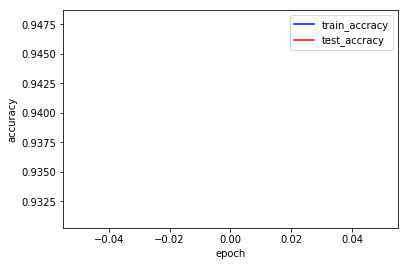

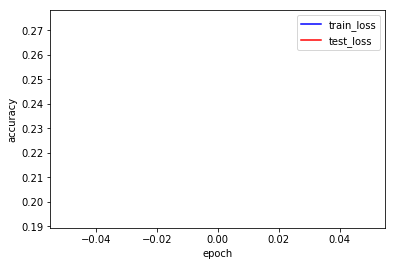

In [161]:
plot_acc_loss(history)